pake dataset dari tmn mama / om axcel

In [110]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization


In [111]:
file_path = r"C:\Users\HP\Documents\data mining\XAUUSD H1.csv"
data = pd.read_csv(file_path)

# Display basic info and the first few rows to understand its structure and confirm columns
data_info = data.info()
data_head = data.head()

data_info, data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83892 entries, 0 to 83891
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   2010.01.03  82003 non-null  object 
 1   23:00       82003 non-null  object 
 2   1097.45     82003 non-null  float64
 3   1100.6      82003 non-null  float64
 4   1095.57     82003 non-null  float64
 5   1095.57.1   82003 non-null  float64
 6   3635        82003 non-null  float64
dtypes: float64(5), object(2)
memory usage: 4.5+ MB


(None,
    2010.01.03 23:00  1097.45   1100.6  1095.57  1095.57.1    3635
 0  2010.01.04  0:00  1096.00  1096.90  1093.08    1094.49  3765.0
 1  2010.01.04  1:00  1094.95  1095.95  1094.00    1095.65  3017.0
 2  2010.01.04  2:00  1095.35  1099.15  1095.28    1097.87  3242.0
 3  2010.01.04  3:00  1097.87  1099.64  1096.95    1098.89  2676.0
 4  2010.01.04  4:00  1098.86  1102.75  1098.52    1101.60  2954.0)

In [112]:
# Bersihkan dan proses data
data.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data = data[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]
data.set_index('Datetime', inplace=True)
data.dropna(inplace=True)

perbaikan

In [113]:
prices = data['Close'].values  # Pastikan kolom harga sesuai dengan dataset Anda
prices = prices.reshape(-1, 1)


In [114]:
# Ambil hanya harga Close untuk prediksi
# skala data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(prices)


perbaikan

In [115]:
# Hyperparameter
sequence_length = 50  # Ubah ke nilai 30, 100, atau lainnya untuk eksperimen
lstm_units = 64       # Ubah ke 50, 100, atau lainnya
dropout_rate = 0.5    # Ubah ke 0.2, 0.4, dll.
epochs = 50           # Ubah jumlah epochs
batch_size = 32       # Ubah ukuran batch


In [116]:
# buat sequence
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, 0])  # Ambil sequence_length data sebelumnya
        y.append(data[i, 0])  # Data target
    return np.array(x), np.array(y)

# Panjang urutan
x, y = create_sequences(data_scaled, sequence_length)


In [117]:
# Bagi data menjadi pelatihan dan pengujian
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [118]:
# Ubah bentuk data
x_train = np.expand_dims(x_train, axis=-1)  # Tambahkan dimensi fitur
x_test = np.expand_dims(x_test, axis=-1)


perbaikan

In [119]:

# Menambahkan Batch Normalization
model = Sequential([
    Input(shape=(sequence_length, 1)),
    LSTM(lstm_units, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(lstm_units, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(25),
    Dense(1)
])


perbaikan

In [120]:

# Menggunakan regularisasi L2 pada LSTM layers
model = Sequential([
    Input(shape=(sequence_length, 1)),
    LSTM(lstm_units, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    LSTM(lstm_units, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(25),
    Dense(1)
])


perbaikan

In [121]:
# Early stopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )


In [122]:
# Buat model dgn beberapa teknik regularisasi 
model = Sequential([
    Input(shape=(sequence_length, 1)),
    LSTM(lstm_units, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(dropout_rate),
    LSTM(lstm_units, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(25),
    Dense(1)
])

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer='adam', loss='mean_squared_error')


In [123]:
# Latih model
history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_test, y_test), 
    epochs=epochs, 
    batch_size=batch_size,
    )

Epoch 1/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 156s 70ms/step - loss: 0.4140 - val_loss: 0.0370
Epoch 2/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 146s 71ms/step - loss: 0.0287 - val_loss: 0.0090
Epoch 3/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 145s 71ms/step - loss: 0.0115 - val_loss: 0.0031
Epoch 4/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 202s 70ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 5/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 144s 70ms/step - loss: 0.0030 - val_loss: 7.1496e-04
Epoch 6/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 145s 71ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 7/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 144s 70ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 8/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 148s 72ms/step - loss: 0.0027 - val_loss: 9.0842e-04
Epoch 9/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 157s 77ms/step - loss: 0.0026 - val_loss: 3.6191e-04
Epoch 10/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 196s 73ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 11/50
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 200s 72ms/step - loss: 0.0026 - va

perbaikan

In [124]:
# Evaluate the model
loss = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")


513/513 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.0035
Test Loss: 0.0036927370820194483


In [125]:
# Prediksi
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


513/513 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step


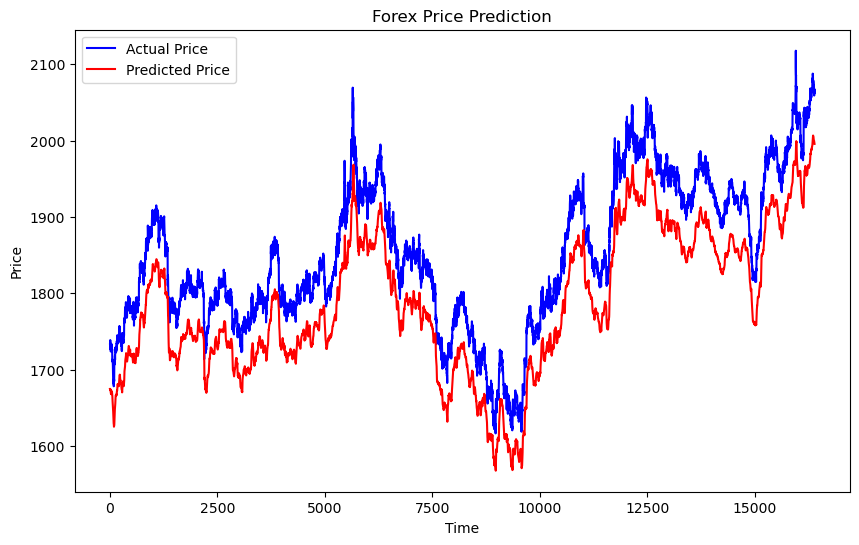

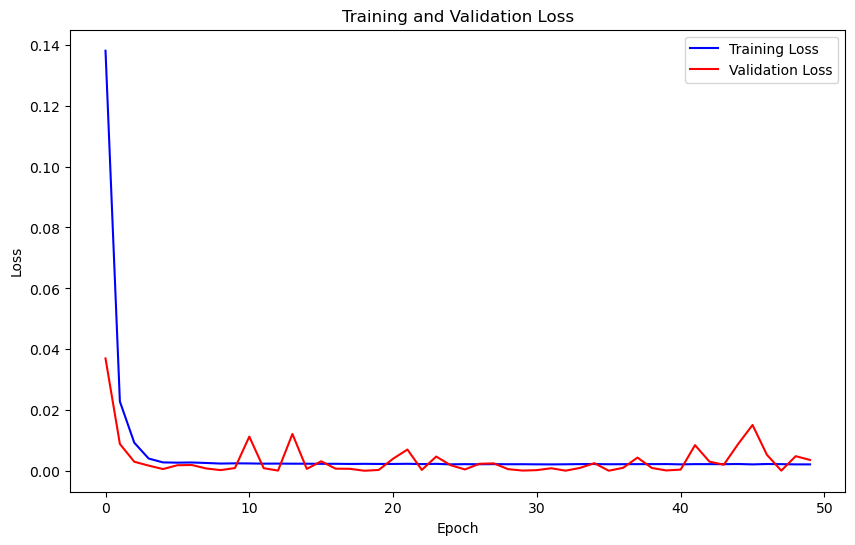

In [126]:
# Evaluasi
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, label="Actual Price", color="blue")
plt.plot(predictions, label="Predicted Price", color="red")
plt.title("Forex Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


tambahan

In [127]:

# Hitung metrik evaluasi
mse = mean_squared_error(y_test_scaled, predictions)
mae = mean_absolute_error(y_test_scaled, predictions)
r2 = r2_score(y_test_scaled, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


Mean Squared Error (MSE): 4095.4188950265684
Mean Absolute Error (MAE): 63.42108435197861
R-squared (R²): 0.5698842170774773


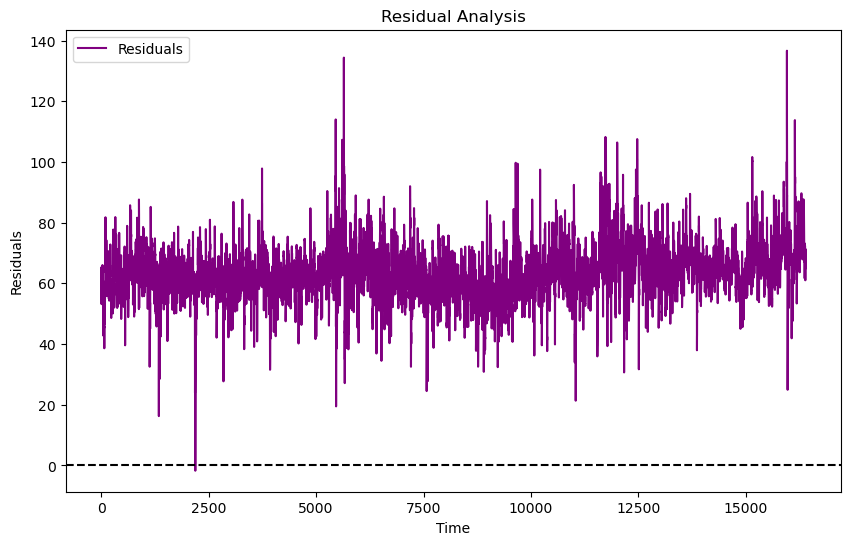

In [128]:
residuals = y_test_scaled - predictions
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residual Analysis')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [129]:
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()
data.dropna(inplace=True)


In [130]:
last_sequence = data_scaled[-sequence_length:]  # Ambil window terakhir
last_sequence = np.expand_dims(last_sequence, axis=0)  # Ubah bentuk
future_prediction = model.predict(last_sequence)
future_prediction = scaler.inverse_transform(future_prediction)
print("Prediksi Harga Masa Depan:", future_prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediksi Harga Masa Depan: [[1995.3975]]


In [131]:
# Simpan model
model.save('my_model.keras')
